In [48]:
import numpy as np
%pylab inline
style.use('ggplot')

# rolling sum for onsets
def stack_onsets(arr):
    stacked = [];c=0.
    for o in arr:
        stacked.append(c+o)
        c+=o
    return np.array(stacked)

# bin onsets by bin_len second?
def bin_onsets(arr,bin_len):
    n_bins = (np.ceil(np.max(arr) / bin_len)) + 1
    bins = np.zeros(n_bins)
    for o in arr:
#         print np.round(o / bin_len)
        bins[np.round(o / bin_len)] += 1
    return np.array(bins)
        

Populating the interactive namespace from numpy and matplotlib


## we want our curve to look like this

![ionizing vs alt](http://rocketsetc.com/wp-content/uploads/2015/05/hab2-geiger2.png)

### estimating this graph and converting ft to time

In [62]:
ascent_fps = 6 # feet per second
bin_len = 10 # length in second of bins
sc = 20 # scaling factor of trend
total_time = 18000 # total time ascending

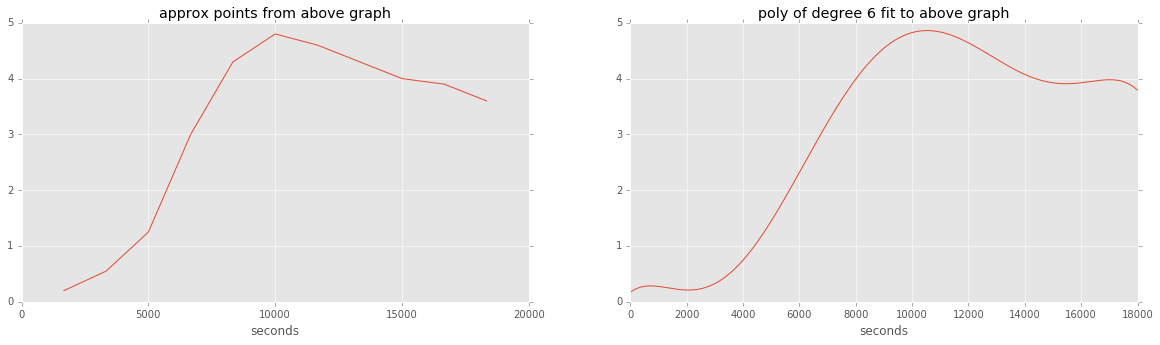

In [63]:
# manually done from graph above
x = np.array([10, 20,  30,40,50,60,70,80,90,100,110]) * 1e3 / ascent_fps
y = np.array([.2,.55,1.25, 3,4.3,4.8,4.6,4.3,4,3.9,3.6])

time_points = np.arange(0,total_time,bin_len)

coefs = np.polyfit(x,y,6) # creating a 6 degree poly to fit this data
# (6 seems to be pretty solid but is completely arbitrary)
poly_y = np.poly1d(coefs) # flattening it?

ys = poly_y(time_points) # fitting this poly to time vector 

figure(figsize=(20,5))
subplot(121)
title('approx points from above graph')
xlabel('seconds')
plot(x,y)
subplot(122)
title('poly of degree 6 fit to above graph')
xlabel('seconds')

plot(np.arange(0,18000,10),ys);show()

### Create onsets of pulses with size in (0,1/div_factor)

In [64]:
div_factor = 4. # completely arbitrary fudge factor to make shit work
# basically this is saying give us about 10 samples per second
n_onsets = np.ceil(np.max(x)) * 10

In [65]:
# these are the raw random numbers in range (0,1/div_factor)
onsetsG1 = np.random.random(size=n_onsets) / div_factor
onsetsG2 = np.random.random(size=n_onsets) / div_factor
onsetsP = np.random.random(size=n_onsets) / div_factor
print onsetsG1

[ 0.18543857  0.0535564   0.02198168 ...,  0.21338739  0.05957673
  0.11373201]


# make these numbers into a running sum

In [66]:
onsetsG1 = stack_onsets(onsetsG1)
onsetsG2 = stack_onsets(onsetsG2)
onsetsP = stack_onsets(onsetsP)
print onsetsG1

[  1.85438566e-01   2.38994969e-01   2.60976647e-01 ...,   2.29538164e+04
   2.29538760e+04   2.29539897e+04]


In [71]:
# hacky bullshit to not go over time ; go with it for now
onsetsG1 = onsetsG1[onsetsG1 < np.max(x) -10]
onsetsG2 = onsetsG2[onsetsG2 < np.max(x) -10]
onsetsP = onsetsP[onsetsP < np.max(x) -10]
onsets = [onsetsG1,onsetsG2,onsetsP]
map(max,onsets)

## we gunna add this shit to the random data so it looks like what that graph says

In [72]:
# ceil of highest value in our time_points
max_time = np.ceil(np.max(map(max,onsets))) + 10
print 'highest time : {}'.format(max_time)

binned = bin_onsets(onsetsG1,bin_len)

x_time_points = np.arange(0,max_time,bin_len)
y_trend = poly_y(x_time_points)

highest time : 18334.0


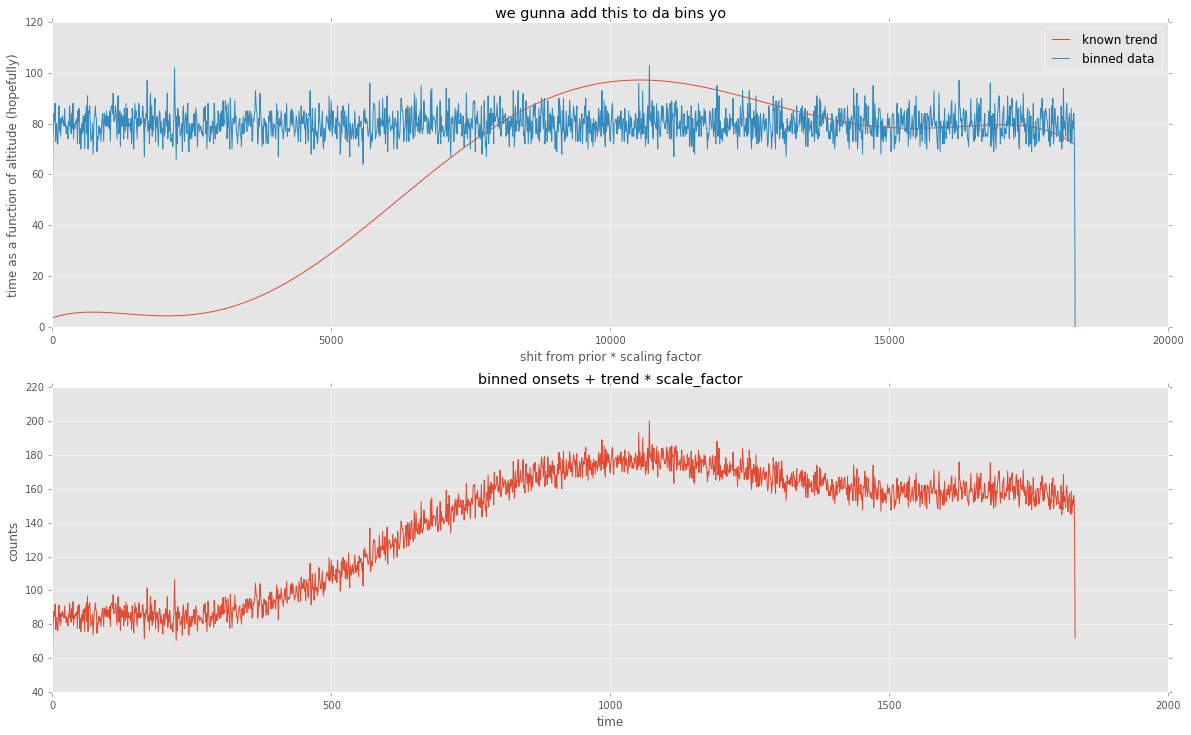

In [74]:
figure(figsize=(20,12))
subplot(211)
plot(x_time_points,y_trend * sc,label='known trend')
plot(x_time_points,binned,label='binned data')
title('we gunna add this to da bins yo')
xlabel('shit from prior * scaling factor')
ylabel('time as a function of altitude (hopefully)')
legend()
subplot(212)
binned = bin_onsets(onsetsG1,bin_len)
plot(binned + (y_trend * sc))
title('binned onsets + trend * scale_factor')
xlabel('time')
ylabel('counts');show()

In [ ]:
# NEXT : 
    # add muons and change PD to only have gamma cuz right now they ==
    # bin all 3 time series (problem with polyfit vector length)
    # try out equation on them to see if we get anything

## currently seperate from above ; sympy shit for our fancy matrix equation 

In [2]:
from sympy.interactive import printing
printing.init_printing()

In [27]:
from sympy import Function, symbols, sqrt, S ,Sum, Abs

In [4]:
P_b,Q_g,C1,C2,C3,P_g = symbols("P_B Q_\gamma C_1 C_2 C_3 P_{\gamma}")

In [5]:
expr = P_b * Q_y * C1 + C2/(1-P_b) - C3 * (P_b - P_g)
expr

NameError: name 'Q_y' is not defined

In [6]:
X = Matrix([[1,1,1],[1,P_b,P_g],[0,0,Q_g]])
X

NameError: name 'Matrix' is not defined

In [7]:
C = Matrix([[C1,C2,C3]]).T
C

NameError: name 'Matrix' is not defined

In [8]:
X*C

NameError: name 'X' is not defined

In [32]:
x, y, n, m, i, k = symbols("x y n m i k")

In [33]:
s1 = sqrt( (1/m)  * Sum(x - Sum(x,[i,0,k])))
s1

ValueError:  specify dummy variables for x - Sum(x, (i, 0, k)). If the integrand contains more than one free symbol, an integration variable should be supplied explicitly e.g., integrate(f(x, y), x)

In [28]:
J = Abs( (  ) # - ( sqrt( (1/n) * Sum(y - Sum(y)/n)^2)))

TypeError: unsupported operand type(s) for ^: 'list' and 'int'

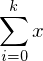

In [25]:
Sum(x,[i,0,k])